# DNN Assignment
In this assignment you are working together with your teammates from the second project. You will apply your new knowledge about dense neural networks to the data from your ML project to investigate, if you can make further improvements on prediction performance. Your data is (hopefully) already cleaned and transformed (this was part of your ML project) such that you can focus fully on feeding it to your neural network. Use TensorFlow 2.x in this assignment as it makes training with real-life data much more easier with many implemented features (e.g. early-stopping, tensorboard, regularization, etc.). 

In this notebook you will learn
- how to apply a neural network to your own data using TensorFlow 2.x
- how to tune the network and monitor learning
- how to train several networks and ensemble them into a stronger model

# Module loading
Load all the necessary packages for your assignment. We give you some modules in advance, feel free to add more, if you need them.

In [1]:
import datetime, time, os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
    
print('Using TensorFlow version: %s' % tf.__version__)

RSEED = 1337

Using TensorFlow version: 2.8.0


In [2]:
!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

## Data loading
Load here your data from your ML project. You can use either `pandas` or `numpy` to format your data. 

In [3]:
# Import Data

data = pd.read_csv('data/data_prep_reg.csv', index_col=[0]) # includes the statistics of the features only location D
#data = pd.read_csv('data/data_prep_feat.csv', index_col=[0]) # includes all values as a new features only location D
#data = pd.read_csv('data/data_prep_reg_all.csv', index_col=[0]) # include the statistics of the features an all locations

print(f'Data: {data.shape}')

Data: (4990, 44)


In [4]:
#fillna
data = data.fillna(data.mean())

In [5]:
data.head()

,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
1,3,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,0.561,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
10,3,55.638261,34.041667,17.191667,23.189507,4.432786,19.649595,22.033333,16.850000,10.302,...,0.533776,0.840833,3.285000,90.986667,90.211667,90.624814,0.179998,0.032399,90.641667,0.775000
13,3,32.240851,29.608333,19.166667,23.151446,2.808773,7.889204,22.291667,10.441667,2.229,...,0.195908,0.627500,1.705000,90.744167,90.102500,90.454477,0.149374,0.022312,90.471667,0.641667
15,3,72.717021,29.133333,17.516667,22.341529,3.161073,9.992384,21.683333,11.616667,13.588,...,0.124645,0.625000,1.608333,90.873333,90.284167,90.607307,0.139059,0.019337,90.620833,0.589167
22,3,35.833571,30.558333,16.983333,22.401240,3.592899,12.908921,21.333333,13.575000,43.080,...,0.186272,0.678333,2.197500,91.004167,90.217500,90.600544,0.172882,0.029888,90.600833,0.786667


In [6]:
columns_to_drop = ['target', 'location']
# define features and target
X = data.drop(columns_to_drop, axis=1)
y = data.target

# test train split: 
X_train, X_test, y_train, y_test = train_test_split(  
                                    X, y, test_size = 0.3, 
                                    random_state = RSEED) 

print (f'X: {X.shape}')
print (f'y: {y.shape}')

print (f'X_train: {X_train.shape}')
print (f'y_train: {y_train.shape}')

print (f'X_test: {X_test.shape}')
print (f'y_test: {y_test.shape}')

X: (4990, 42)
y: (4990,)
X_train: (3493, 42)
y_train: (3493,)
X_test: (1497, 42)
y_test: (1497,)


## Training
For training you need a train/val split (hopefully you did a train/test split before (and you should use the same as in your ML project to make results comparable). 

In [7]:
N_VAL =  len(X_test)
N_TRAIN = len(X_train)
BATCH_SIZE = 96
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
EPOCHS = 2000

### Build, compile and fit your model
To become fast at retraining your (different) models it is good practice to define a function that gets fed by a model, its name, an optimizer to use and the number of epochs you want the model to be trained. 

If your model trains for many epochs you will receive a lot of logging from TensorFlow. To reduce the logging noise you can use a callback (provided by the `tensorflow_docs` module we installed and imported for you) named `EpochDots()` that simply prints a `.` for each epoch and a full set of metrics after a number of epochs have been trained. 

If you want to produce logs for using Tensorboard you also need to include the `callbacks.Tensorboard()`.

In [8]:
# aktiviert
!rm -rf my_logs/


In [9]:
# preparation for Tensorboard

# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir()
#def get_callbacks():

def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

In [10]:
# checkpoint 

# Define path where checkpoints should be stored
checkpoint_path = "DNN/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1) # Set verbose != 0 if you want output during training


In [11]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [12]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    #ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    #ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    #ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));


You can implement your callbacks in the `model.fit()` method below.

In [13]:
# Define dictionary to store results
training_history = {}

In [23]:
def model_compile_and_fit(X, y, model, name, optimizer, max_epochs=30):
    # Get optimizer
    #optimizer=tf.keras.optimizers.Adam()

    # model.compile
    model.compile(optimizer=optimizer,
                metrics='mse',
                loss='mae')
    # model.fit
    training_history[name] = model.fit(X, 
                        y,
                        validation_split=0.2,
                        verbose=1,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        callbacks=get_callbacks(name))
    # return results
    return training_history[name]



#### Build your model
You can build your model by using `tf.keras.Sequential()` that helps you to sequentially define your different layers from input to output. 

In [15]:
with tf.device('/cpu:0'):
      first_model = tf.keras.Sequential([
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 42),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
      ])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-07 13:13:19.074965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-07 13:13:19.075315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Train your model
Train your model by using your `model_compile_and_fit()` function you defined above.

In [16]:
with tf.device('/cpu:0'):
    first_model_history = model_compile_and_fit(X=X_train, 
                                            y=y_train,
                                            model= first_model,
                                            name='first_model',
                                            optimizer='Adam', 
                                            max_epochs= EPOCHS )


Epoch 1/2000


2022-04-07 13:13:19.200003: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36/36 [==============================] - 1s 13ms/step - loss: 29.7005 - mse: 1969.3503 - val_loss: 21.9330 - val_mse: 1065.6794
Epoch 2/2000
36/36 [==============================] - 0s 13ms/step - loss: 21.5844 - mse: 962.6286 - val_loss: 21.6909 - val_mse: 1043.1777
Epoch 3/2000
36/36 [==============================] - 1s 15ms/step - loss: 22.2298 - mse: 1005.0605 - val_loss: 21.3332 - val_mse: 1004.4832
Epoch 4/2000
36/36 [==============================] - 0s 12ms/step - loss: 21.9814 - mse: 988.2955 - val_loss: 21.0663 - val_mse: 966.5383
Epoch 5/2000
36/36 [==============================] - 0s 12ms/step - loss: 21.6768 - mse: 962.8329 - val_loss: 21.1134 - val_mse: 920.7587
Epoch 6/2000
36/36 [==============================] - 0s 11ms/step - loss: 21.4232 - mse: 949.0943 - val_loss: 21.0138 - val_mse: 921.9423
Epoch 7/2000
36/36 [==============================] - 0s 10ms/step - loss: 21.4125 - mse: 946.7532 - val_loss: 22.2382 - val_mse: 1107.5740
Epoch 8/2000
36/36 [==============

#### Evaluate your model training
TensorFlow offers now (this was more cumbersome before) a simple history plotter that you can use to plot training histories and see how the model performed on training and validation data set.

In [17]:
"""
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=10)
history_plotter.plot(history_plotter)"""

AttributeError: 'HistoryPlotter' object has no attribute 'items'

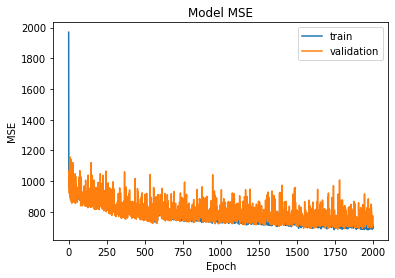

47/47 - 0s - loss: 19.3927 - mse: 825.1370 - 130ms/epoch - 3ms/step
Model MSE: 825.136962890625
----------------------------------------
RMSE: 28.72519566456275
RMSE: 26.17898986347043


In [22]:
with tf.device('/cpu:0'):
    # plot MSE history 
    plot_metric(first_model_history)

    # Evaluate the small model on test set using .evaluate
    loss, mse = first_model.evaluate(X_test, y_test, verbose=2)
    print(f'Model MSE: {mse}')
    print('--------'*5)

# Predict values for test set
y_pred = first_model.predict(X_test)
y_pred_train = first_model.predict(X_train)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

In [35]:
y_pred.ravel()

array([40.60985 , 45.53222 , 53.890533, ..., 49.18707 , 36.608192,
       52.083664], dtype=float32)

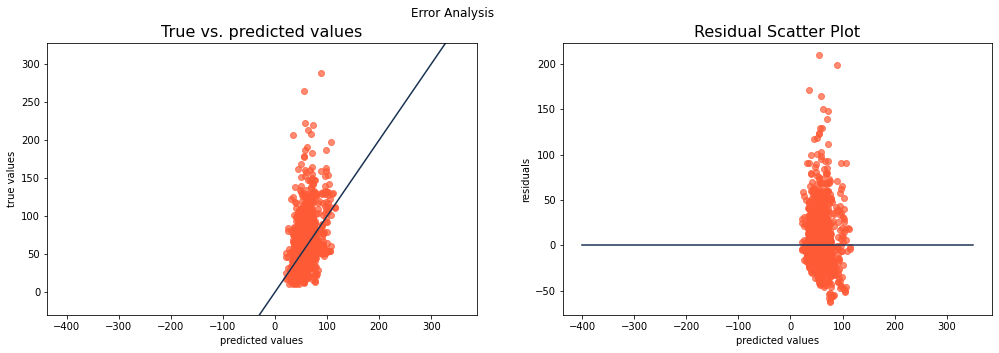

In [36]:
error_analysis(y_test, y_pred.ravel())

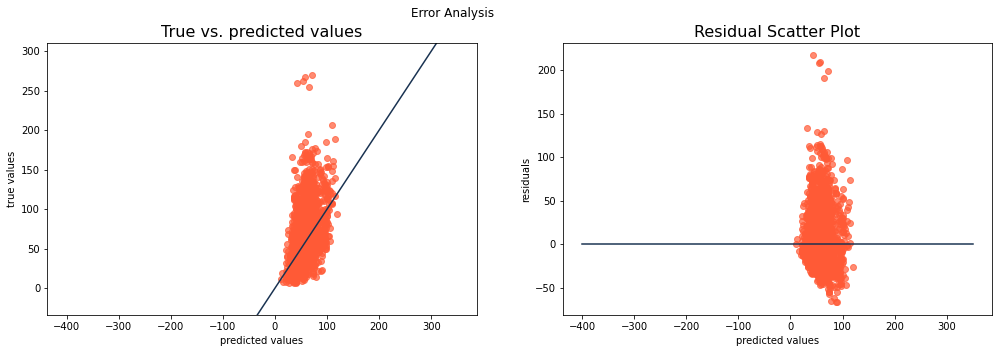

In [37]:
error_analysis(y_train, y_pred_train.ravel())

## Model tuning
You might have no luck with your first model (most surely you did not). In this section you will apply methods you know to tune your model's performance. An obvious way of course is to change your model's architecture (removing or adding layers or layer dimensions, changing activation functions). 

However, after this you might still be able to detect some overfitting and there are some more methods you can apply to improve your neural network. Some of them are regularization, learning rate decay, early stopping, or dropout. 

If you want to add regularization you can apply directly layer-wise L2- or L1-regularization by using a layer's `kernel_regularization` argument and an appropriate regularizer from the [`tensorflow.keras.regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) module we imported for you.  

__Optimizer schedules__<br>
Quite often your optimizer does not run efficiently through the loss function surface. Remember that theory ensures a convergence of mini-batch SGD if and only if the learing rate decreases sufficiently fast. A way to apply this to your model training is to use a learning rate scheduler (learning rate decay) that reduces the learning rate over the number of update steps. The [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) module offers you some approaches to do that. 

Note that to apply this to your `model_compile_and_fit()` function you defined above you need to implement the learning rate schedule either in there or with a helper function that your function calls inside. 

If you want to visualize different schedulers you can define them and call them on a range of values and plot them in a line plot. 

__Early stopping__<br>
Earyl stopping is a procedure that enables you to stop your training earlier than defined by your `max_epochs` argument. It is used in practices to 
1. determine the optimal parameter vector by monitoring the validation error closely (if it rises again too much stuck with the best parameters found until then) and
2. to save expensive resources (either in terms of monetary costs or ecological costs).

To implement early stopping in TensorFlow the `tf.keras` module offers you a `callback` named [`tf.keras.callback.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) that monitors for you a certain metric (it makes sense here to use a validation metric) and to stop training after a certain number of epochs with no improvement or by defining a certain `min_delta` that defines a minimum value of improvement - if below the callback stops your training. 

You can add this callback simply to the callbacks defined in your `get_callbacks()` function you defined above.

__Dropout__<br>
Dropout was one of the important developments in regularization for neural networks. It was developed by Geoffrey Hinton and his team at Toronto University. 

Dropout can be applied to each layer in your network and is implemented in `tf.keras` by an own layer named `Dropout()` awaiting a dropout rate set by you. So to introduce dropout you have to rework your model design.  

Make use of your knowledge and apply tuning techniques to improve your network. 

### Normalization


In [ ]:
# Normalization
with tf.device('/cpu:0'):
    normal_model = tf.keras.Sequential([
            tf.keras.layers.Normalization(axis=1),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 42),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
      ])

with tf.device('/cpu:0'):
    first_model_history = model_compile_and_fit(X=X_train, 
                                            y=y_train,
                                            model= first_model,
                                            name='first_model',
                                            optimizer='Adam', 
                                            max_epochs= EPOCHS )

In [ ]:

history_plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=10)
history_plotter.plot(history_plotter)

In [ ]:
with tf.device('/cpu:0'):
    # plot MSE history 
    plot_metric(first_model_history)

    # Evaluate the small model on test set using .evaluate
    loss, mse = first_model.evaluate(X_test, y_test, verbose=2)
    print(f'Model MSE: {mse}')
    print('--------'*5)

# Predict values for test set
    y_pred = first_model.predict(X_test)
    print('MSE:', mean_squared_error(y_test, y_pred))

### Regularisation

In [ ]:
# l2 regularisation

In [ ]:
# schedules https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules

In [ ]:
# early stopping : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# drop

In [ ]:
# kernel initializer leaky Relu : https://keras.io/api/layers/activation_layers/leaky_relu/

## Model ensembling
You have learned that models can be ensembled. What is possible in `scikit-learn` is also possible in TensorFlow, just a little different as it is relying on its computation graph. However, any model is callable like a `layer` by invoking it on either an `Input` or on the output of another layer. Furthermore, you can also stack outputs together.

To produce an ensemble you can define a couple of models, than use their predictions as inputs for another model and produce a final output (using `keras.Model(input, output)`). But you can also start simple and use the mean predictions over all models and then compute the `argmax()` to assign them to a class in classification (via using `layers.average([model1_preds,model2_preds,...])`). You will be surprised how well this works. 

Now implement your own ensemble to improve your work even a little more and to have something more to polish up your ML project on `GitHub` ;) 

In [ ]:
#===========#
# YOUR CODE #
#===========#

In [42]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir=./my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7305), started 0:00:10 ago. (Use '!kill 7305' to kill it.)